In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, locally_linear_embedding

### Ascertain that the untrained model weights are random

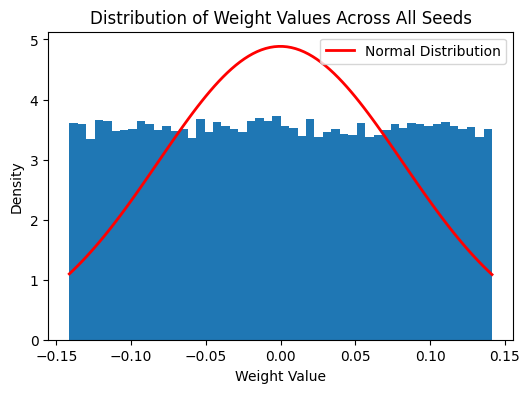

Mean of weights: -0.0002
Std of weights: 0.0817
Min of weights: -0.1414
Max of weights: 0.1414


In [4]:
model_type = 'fully_connected'
dataset_type = 'mnist'
untrained = True
untrained_string = '-untrained' if untrained else ''

# Collect weights from all seeds and analyze their distribution
all_weights = []
models = []
for seed in range(100):
    model = torch.load(f'saved_models/{model_type}-{dataset_type}{untrained_string}-hidden_dim_[50,50]/seed-{seed}')
    models.append(model)
    weights = model['layers.2.weight'].cpu().detach()
    all_weights.append(weights.numpy().flatten())

# Convert to numpy array for easier analysis
all_weights = np.array(all_weights)

# Create histogram of weights across all seeds
plt.figure(figsize=(6, 4))
plt.hist(all_weights.flatten(), bins=50, density=True)
plt.title('Distribution of Weight Values Across All Seeds')
plt.xlabel('Weight Value')
plt.ylabel('Density')

# Add a reference normal distribution
from scipy.stats import norm
x = np.linspace(all_weights.min(), all_weights.max(), 100)
plt.plot(x, norm.pdf(x, all_weights.mean(), all_weights.std()), 
         'r-', lw=2, label='Normal Distribution')
plt.legend()
plt.show()

# Print some statistics
print(f"Mean of weights: {all_weights.mean():.4f}")
print(f"Std of weights: {all_weights.std():.4f}")
print(f"Min of weights: {all_weights.min():.4f}")
print(f"Max of weights: {all_weights.max():.4f}")

### Make sure trained underlying models do indeed solve mnist

In [5]:
import torch
import numpy as np
from tqdm import tqdm
import os

from datasets.MNIST import MNISTDataModule
from pytorch_models.fully_connected import FullyConnected, FullyConnectedDropout, FullyConnectedGenerative

# Class mappings (same as in main.py)
MODEL_MAP = {
    'fully_connected': FullyConnected,
    'fully_connected_dropout': FullyConnectedDropout,
}

def evaluate_model(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluate a model on a dataloader and return accuracy
    """
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            inputs = inputs.view(inputs.size(0), -1)
                
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def test_model(model_type, dataset_type, seed, untrained="", hidden_dim=None):
    """
    Load and test a model on the MNIST validation set
    
    Args:
        model_type (str): Type of model (e.g., 'fully_connected')
        dataset_type (str): Type of dataset (e.g., 'mnist')
        seed (int): Seed number
        untrained (str): Empty string or '-untrained' for untrained models
    
    Returns:
        float: Accuracy percentage on validation set
    """
    # Set up data module
    data_module = MNISTDataModule(batch_size=256, num_workers=4, data_path="./underlying/data")
    data_module.prepare_data()
    data_module.setup(stage='validate')
    
    # Get model path
    model_path = f'saved_models/{model_type}-{dataset_type}{untrained}-hidden_dim_[50,50]/seed-{seed}'
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at path: {model_path}")
    
    # Create model instance of the correct type
    model_class = MODEL_MAP[model_type]
    input_dim = data_module.input_dim
    model = model_class(num_classes=10, input_dim=input_dim, hidden_dim=hidden_dim)
    
    # Load the state dictionary
    model.load_state_dict(torch.load(model_path))
    
    # Get validation dataloader
    val_dataloader = data_module.val_dataloader()
    
    # Evaluate the model
    accuracy = evaluate_model(model, val_dataloader)
    
    return accuracy

In [6]:
# Set parameters
hidden_dim = [50, 50]
dataset_type = "mnist"
num_seeds = 10

# Dictionary to store results for each model
results = {
    "untrained": [],
    "fully_connected": [],
    "fully_connected_dropout": []
}

# Run evaluation for each model across seeds
for seed in range(num_seeds):
    print(f"Evaluating seed {seed}...")
    
    # Untrained model
    print("untrained")
    accuracy = test_model("fully_connected", dataset_type, seed, "-untrained", hidden_dim)
    results["untrained"].append(accuracy)
    
    # Fully connected model
    print("fully_connected")
    accuracy = test_model("fully_connected", dataset_type, seed, "", hidden_dim)
    results["fully_connected"].append(accuracy)
    
    # Fully connected with dropout
    print("fully_connected_dropout")
    accuracy = test_model("fully_connected_dropout", dataset_type, seed, "", hidden_dim)
    results["fully_connected_dropout"].append(accuracy)

# Calculate means and standard deviations
means = {model: np.mean(accs) for model, accs in results.items()}
stds = {model: np.std(accs) for model, accs in results.items()}

Evaluating seed 0...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]


Evaluating seed 1...
untrained


Evaluating: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.72it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Evaluating seed 2...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.71it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.02it/s]


Evaluating seed 3...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.14it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.05it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.00it/s]


Evaluating seed 4...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.62it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.08it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.09it/s]


Evaluating seed 5...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.26it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.62it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.35it/s]


Evaluating seed 6...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.72it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.31it/s]


Evaluating seed 7...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.35it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.50it/s]


Evaluating seed 8...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.49it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.83it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s]


Evaluating seed 9...
untrained


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.27it/s]


fully_connected


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


fully_connected_dropout


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


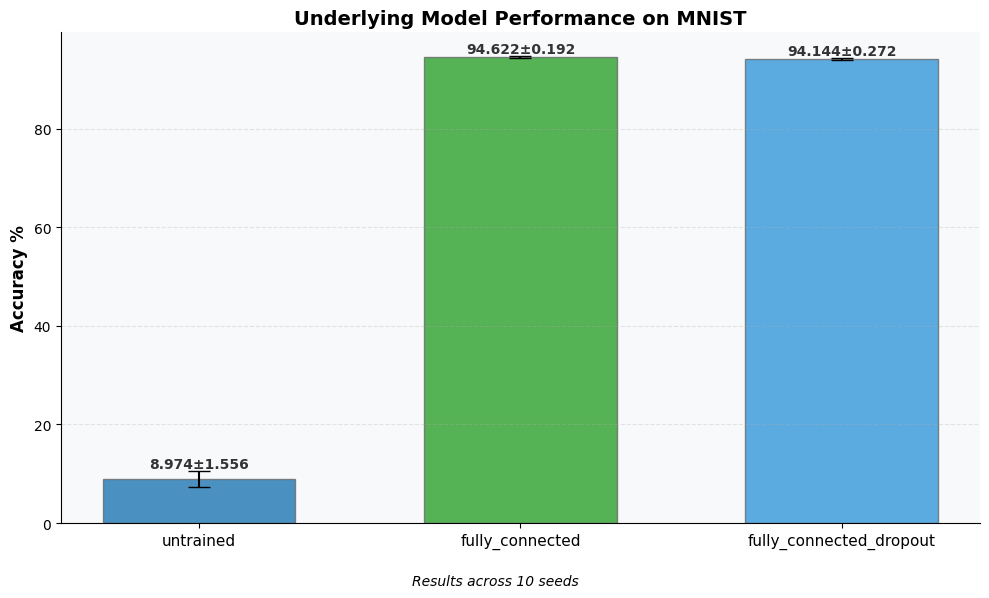

In [7]:
# Create bar chart
plt.figure(figsize=(10, 6))
models = list(results.keys())
x_pos = np.arange(len(models))

# Define a nice color palette of blues and greens
colors = ['#1f77b4', '#2ca02c', '#3498db', '#2ecc71', '#21618c', '#28b463']
if len(models) > len(colors):
    # If we have more models than colors, cycle through the colors
    colors = colors * (len(models) // len(colors) + 1)

# Make bars thinner by adjusting width parameter
plt.bar(x_pos, [means[m] for m in models], yerr=[stds[m] for m in models], 
        align='center', alpha=0.8, capsize=8, color=colors[:len(models)],
        edgecolor='dimgray', linewidth=1, width=0.6)  # Reduced width for thinner bars

# Improve the styling
plt.xticks(x_pos, models, fontsize=11, rotation=30 if len(models) > 4 else 0, ha='right' if len(models) > 4 else 'center')
plt.ylabel('Accuracy %', fontsize=12, fontweight='bold')
plt.title(f'Underlying Model Performance on {dataset_type.upper()}', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add a subtle background color
plt.gca().set_facecolor('#f8f9fa')
plt.rcParams['axes.axisbelow'] = True

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add text labels on top of bars - improved visibility
for i, model in enumerate(models):
    plt.text(i, means[model] + stds[model] + 0.01, 
             f'{means[model]:.3f}±{stds[model]:.3f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

# Add a note about the seeds - improved position and visibility
plt.figtext(0.5, 0.01, f'Results across {num_seeds} seeds', 
            ha='center', va='bottom', fontsize=10, fontstyle='italic', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the seeds note
plt.savefig(f'{dataset_type}_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Readout weights - relational analysis

torch.Size([10, 50])


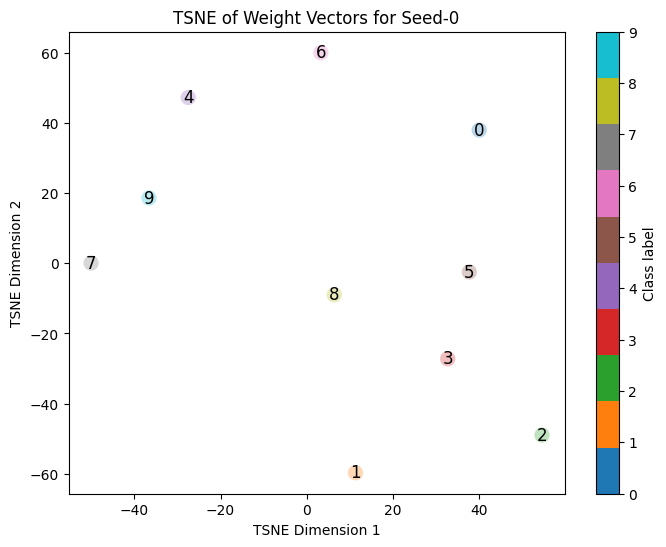

In [8]:
model_type = 'fully_connected_dropout'
dataset_type = 'mnist'
weight_matrices = []
untrained = False
untrained_string = 'untrained' if untrained else ''
n_seeds_to_plot = 1
for seed in range(n_seeds_to_plot):
    model = torch.load(f'saved_models/{model_type}-{dataset_type}{untrained_string}-hidden_dim_[50,50]/seed-{seed}')
    weights = model['layers.2.weight'].cpu().detach()

    print(weights.shape)
    # reduce dimensionality of weights
    # You can switch between PCA and TSNE; here we use TSNE as in your code.
    weights_reduced = TSNE(n_components=2, learning_rate='auto',
                           init='random', perplexity=3).fit_transform(weights)

    num_displayed_dots = 10  # assuming we have exactly 10 classes
    classes = list(range(num_displayed_dots))  # class labels 0 to 9

    plt.figure(figsize=(8, 6))
    # Use a discrete colormap (tab10) so that each class gets a unique color.
    scatter = plt.scatter(weights_reduced[:num_displayed_dots, 0],
                          weights_reduced[:num_displayed_dots, 1],
                          c=classes, cmap='tab10', s=100)
    
    # Add a colorbar with class ticks (optional)
    cbar = plt.colorbar(scatter, ticks=classes)
    cbar.set_label('Class label')

    # Annotate each point with its class label.
    for i, cls in enumerate(classes):
        plt.text(weights_reduced[i, 0],
                 weights_reduced[i, 1],
                 str(cls),
                 fontsize=12,
                 ha='center',
                 va='center',
                 color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title(f'TSNE of Weight Vectors for Seed-{seed}')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.show()

### Input neurons

In [9]:
def idx2xy(i, width=28):
  """Converts flat index i (row-major) to (x, y) coords."""
  return (i % width, i // width)

In [10]:
### test idx2xy mapping
from datasets.MNIST import MNISTDataModule
import random
dm = MNISTDataModule(batch_size=1, num_workers=0, data_path="./underlying/data")
dm.prepare_data()
dm.setup(stage='test')

# 2. Get a random image from the test set
num_test_images = len(dm.test)
random_index = random.randint(0, num_test_images - 1)
print(f"Choosing random image at index: {random_index}")
image_tensor_with_channel, label = dm.test[random_index] # Shape [1, 28, 28]

# Remove channel dimension for easier 2D indexing
image_tensor_2d = image_tensor_with_channel.squeeze(0) # Shape [28, 28]
height, width = image_tensor_2d.shape

# 3. Flatten the tensor using PyTorch's standard method
flattened_tensor = image_tensor_2d.flatten() # Shape [784]
num_pixels = flattened_tensor.numel() # Should be 784

# 4. Perform the validation check
print(f"\nValidating idx2xy mapping against torch.flatten() for image index {random_index} (Label: {label})...")

mapping_correct = True
mismatches_found = []

for i in range(num_pixels):
    # a. Calculate coordinates using our function
    x, y = idx2xy(i, width=width)

    # b. Get value from the original 2D tensor using calculated (y, x)
    #    Tensor is indexed [Height, Width] -> [y, x]
    value_from_coords = image_tensor_2d[y, x]

    # c. Get value from the standard flattened tensor using index i
    value_from_flat = flattened_tensor[i]

    # d. Compare the values (use torch.isclose for float tolerance)
    if not torch.isclose(value_from_coords, value_from_flat):
        mapping_correct = False
        mismatches_found.append((i, x, y, value_from_coords.item(), value_from_flat.item()))
        # Optional: break on first mismatch for speed
        # break

# 5. Report Result
if mapping_correct:
    print("\n-------------------------------------------------------------")
    print("SUCCESS: idx2xy mapping is consistent with torch.flatten().")
    print(f"Checked {num_pixels} pixels. Values match for all indices.")
    print("-------------------------------------------------------------")

    # Display a few examples
    print("\nExample checks:")
    indices_to_show = [0, 27, 28, width * height // 2, num_pixels - 1]
    for i_check in indices_to_show:
        if 0 <= i_check < num_pixels:
            x_check, y_check = idx2xy(i_check, width)
            val_coords = image_tensor_2d[y_check, x_check]
            val_flat = flattened_tensor[i_check]
            print(f"  i={i_check:<4} -> (x={x_check:<2}, y={y_check:<2}) | "
                  f"Val@Coords({y_check},{x_check})={val_coords:<8.4f} | "
                  f"Val@Flat[{i_check}]={val_flat:<8.4f} | "
                  f"Match: {torch.isclose(val_coords, val_flat)}")
else:
    print("\n-------------------------------------------------------------")
    print("ERROR: Mismatch found between idx2xy mapping and torch.flatten()!")
    print("-------------------------------------------------------------")
    print("First few mismatches (index, x, y, value_from_coords, value_from_flat):")
    for mismatch in mismatches_found[:10]:
        print(f"  i={mismatch[0]:<4} -> (x={mismatch[1]:<2}, y={mismatch[2]:<2}) | "
              f"Val@Coords={mismatch[3]:<8.4f} | Val@Flat={mismatch[4]:<8.4f}")


Choosing random image at index: 2875

Validating idx2xy mapping against torch.flatten() for image index 2875 (Label: 9)...

-------------------------------------------------------------
SUCCESS: idx2xy mapping is consistent with torch.flatten().
Checked 784 pixels. Values match for all indices.
-------------------------------------------------------------

Example checks:
  i=0    -> (x=0 , y=0 ) | Val@Coords(0,0)=-0.4242  | Val@Flat[0]=-0.4242  | Match: True
  i=27   -> (x=27, y=0 ) | Val@Coords(0,27)=-0.4242  | Val@Flat[27]=-0.4242  | Match: True
  i=28   -> (x=0 , y=1 ) | Val@Coords(1,0)=-0.4242  | Val@Flat[28]=-0.4242  | Match: True
  i=392  -> (x=0 , y=14) | Val@Coords(14,0)=-0.4242  | Val@Flat[392]=-0.4242  | Match: True
  i=783  -> (x=27, y=27) | Val@Coords(27,27)=-0.4242  | Val@Flat[783]=-0.4242  | Match: True


In [11]:

dataset_type = 'mnist'
model_dropout = torch.load(f'saved_models/fully_connected_dropout-{dataset_type}-hidden_dim_[50,50]/seed-0')
model_no_dropout = torch.load(f'saved_models/fully_connected-{dataset_type}-hidden_dim_[50,50]/seed-0')

In [12]:
def display_pixel_map(vector, width=28):
    # 1. Create an empty 2D array (height, width)
    pixel_map = np.zeros((width, width), dtype=float)

    # 2. Iterate through the flat vector
    for i, value in enumerate(vector):
        # Get the (x, y) coordinates for the flat index i
        x, y = idx2xy(i, width=width)
        # Assign the value to the map using [row, column] indexing
        pixel_map[y, x] = value

    # 3. Display the reconstructed map (optional)
    plt.imshow(pixel_map, cmap='viridis', interpolation='nearest')
    plt.colorbar()


Text(0, 0.5, 'Neuron Y position')

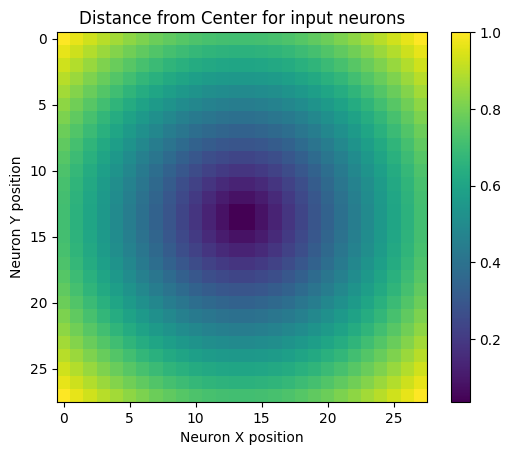

In [18]:
import math
def display_pixel_map(vector, width=28):
    # 1. Create an empty 2D array (height, width)
    pixel_map = np.zeros((width, width), dtype=float)

    # 2. Iterate through the flat vector
    for i, value in enumerate(vector):
        # Get the (x, y) coordinates for the flat index i
        x, y = idx2xy(i, width=width)
        # Assign the value to the map using [row, column] indexing
        pixel_map[y, x] = value

    # 3. Display the reconstructed map (optional)
    plt.imshow(pixel_map, cmap='viridis', interpolation='nearest')
    plt.colorbar()
distances = []
for i in range(28):
    for j in range(28):
        dist = math.sqrt((i - 13.5)**2 + (j - 13.5)**2)
        max_dist = math.sqrt(13.5**2 + 13.5**2)
        distances.append(dist/max_dist)
distance_from_center = np.array(distances)
display_pixel_map(distance_from_center)
plt.title('Distance from Center for input neurons')
plt.xlabel('Neuron X position')
plt.ylabel('Neuron Y position')

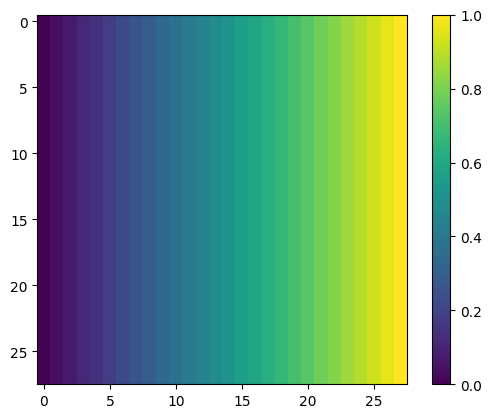

In [14]:
def create_lr_gradient_vector(w=28):
  """Generates a vector for a left-to-right gradient (0.0=left, 1.0=right)."""
  # Create a grid where the value is just the x-coordinate
  # 'indexing='xy'' ensures x varies along columns (left-to-right)
  x, _ = np.meshgrid(np.arange(w), np.arange(w), indexing='xy')

  # Normalize x-coordinate to be between 0.0 and 1.0
  # Add epsilon for the case w=1 to avoid division by zero
  norm_factor = float(w - 1) + 1e-9
  pixel_map_2d = x / norm_factor

  # Ensure values are clipped just in case and flatten to 1D vector
  return np.clip(pixel_map_2d, 0.0, 1.0).flatten()

output_norms = display_pixel_map(create_lr_gradient_vector())

In [15]:
weights_layer0 = model_dropout['layers.0.weight'].cpu().detach()


In [16]:
import umap.umap_ as umap

weights_normalized = weights_layer0 / (weights_layer0.norm(dim=0, keepdim=True) + 1e-9)

cosine_similarities_all_pairs = torch.matmul(weights_normalized.T, weights_normalized)
cosine_similarities_np = cosine_similarities_all_pairs.cpu().numpy()

reducer = umap.UMAP(n_components=2,
                   n_neighbors=15, # Adjust as needed
                   min_dist=0.1,   # Adjust as needed
                   random_state=42)
similarities_reduced = reducer.fit_transform(cosine_similarities_np)

/opt/miniconda3/envs/intentionality/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/intentionality/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/intentionality/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


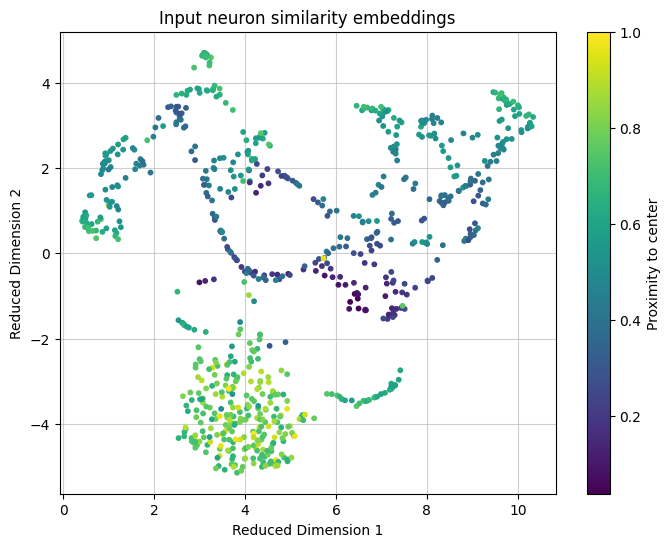

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    similarities_reduced[:, 0],
    similarities_reduced[:, 1],
    c=distance_from_center,
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label='Proximity to center')
plt.xlabel('Reduced Dimension 1')
plt.ylabel('Reduced Dimension 2')
plt.title('Input neuron similarity embeddings')
plt.grid(True, alpha=0.6)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform   # pip install scipy if needed

def radial_similarity_curve(weights_layer0, img_size=28, bins=None, device='cpu'):
    """
    Compute ⟨cosθ⟩ as a function of pixel-grid distance d for one network.

    Args
    ----
    weights_layer0 : torch.Tensor  shape (hidden_dim, img_size*img_size)
        Column j contains the outgoing weights of input neuron j.
    img_size       : int          width/height of the input grid (MNIST = 28).
    bins           : 1-D arraylike of distances at which to sample the curve.
                     Default = [0, 1, 2, …, img_size-1].
    device         : 'cpu' or 'cuda'.

    Returns
    -------
    d_vals : np.ndarray  (len(bins),)
    sim    : np.ndarray  (len(bins),)  average cosine similarity at each d.
    """
    W = weights_layer0.to(device)                       # (H, 784)
    W_norm = W / (W.norm(dim=0, keepdim=True) + 1e-9)   # column‑wise ℓ2 normalisation
    cos = torch.matmul(W_norm.t(), W_norm).cpu().numpy()# (784, 784)

    # pre‑compute all pairwise Euclidean distances between pixel coordinates
    coords = np.array([(i, j) for i in range(img_size) for j in range(img_size)])
    dists  = squareform(pdist(coords, metric='euclidean'))

    if bins is None:
        bins = np.arange(img_size)        # 0, 1, …, 27 pixels
    bins = np.asarray(bins)

    sim = np.empty_like(bins, dtype=float)
    for k, d in enumerate(bins):
        mask = (np.round(dists) == d)     # integer‑distance shell
        sim[k] = cos[mask].mean() if mask.any() else np.nan
    return bins, sim

x = 2

weights_no_dropout = model_no_dropout['layers.0.weight'].cpu().detach()
weights_with_dropout = model_dropout['layers.0.weight'].cpu().detach()  

d, sim_no = radial_similarity_curve(weights_no_dropout)
_, sim_do = radial_similarity_curve(weights_with_dropout)

plt.figure(figsize=(6,4))
plt.plot(d, sim_no, label='no dropout')
plt.plot(d, sim_do, label='dropout')
plt.xlabel('Pixel‑grid distance  d  (pixels)')
plt.ylabel('Mean cosine similarity  ⟨cos θ⟩')
plt.title('Inter‑pixel weight‑similarity vs. distance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'model_no_dropout' is not defined

In [ ]:
# Create matrix of cosine similarities between input neurons using torch
cosine_similarities = torch.nn.functional.cosine_similarity(weights_no_dropout, weights_no_dropout, dim=0)
display_pixel_map(cosine_similarities.numpy())


NameError: name 'torch' is not defined